<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/Yihan_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bitcoin Price and its Movement Direction Prediction**
*Using Linear Regression, Logistics Regression, ARIMA, Simple RNN and LSTM Models.*

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Packages**

In [131]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import datetime as datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN, Flatten
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint

#**Data Cleaning**

Import Dataset

In [132]:
df = pd.read_csv("/content/drive/MyDrive/BA780 Team Project/same but more copy of bitcoin data file in case it's missing/bitcoin.csv")

Modify Timestamp

In [32]:
# Change the Timestamp column attribute to datetime
##df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
# Enable to refer to the row by index
##df = df.set_index('Timestamp')

In [161]:
# in date instead of in seconds
# just Yihan's idea, may not right
df["Date"] = pd.to_datetime(df["Timestamp"],unit="s").dt.date
df = df.groupby("Date").mean()
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,,
2011-12-31,1325346930,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


Spot the missing values

In [162]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missed = missed.sort_values('percent',ascending=False)
missed = missed[missed['percent']>0]


Fill in the missing data

In [163]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()
    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()
    
fill_missing(df)

Remove NA rows

In [164]:
df = df.dropna()

# **Feature Engineering**

Add `Price` column by averaging Low and Close

In [165]:
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)

Add `Return` Column by calculating the difference from now to previous second's `Price`

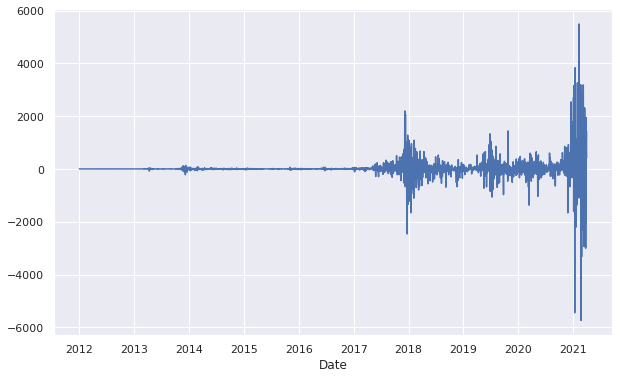

In [166]:
df["Return"] = df["Price"].diff()
df["Return"].plot(x="Timestamp", y="Return")

Add `Direction` column showing if bitcoin price is going up or down.

In [167]:
df["Direction"] = pd.Series(df["Return"] > 0)
df["Direction"] = "Down"
df.loc[(df["Return"] > 0), "Direction"] = "Up"

Add `Percentage_Return` column to show the perentage return per seconds

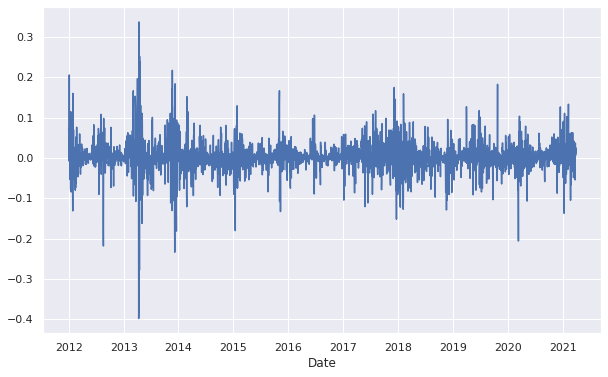

In [168]:
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Percentage_Return"].plot()

Add Lag1, Lag2, Lag3, Lag4, Lag5 columns as t-1, t-2, t-3, t-4, and t-5 features to predict bitcoin price at t (in seconds)

In [169]:
df["Lag1"]= df["Percentage_Return"].shift(periods=-1)
df["Lag2"]= df["Percentage_Return"].shift(periods=-2)
df["Lag3"]= df["Percentage_Return"].shift(periods=-3)
df["Lag4"]= df["Percentage_Return"].shift(periods=-4)
df["Lag5"]= df["Percentage_Return"].shift(periods=-5)
df.dropna()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Date,,,,,,,,,,,,,,,,,
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667,0.332917,Up,0.074416,0.040222,0.050500,-0.007774,0.205720,0.024856
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000,0.193333,Up,0.040222,0.050500,-0.007774,0.205720,0.024856,0.055901
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500,0.252500,Up,0.050500,-0.007774,0.205720,0.024856,0.055901,0.022059
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.211667,-0.040833,Down,-0.007774,0.205720,0.024856,0.055901,0.022059,-0.052818
2012-01-05,1325764770,6.281429,6.286190,6.281429,6.286190,4.514373,27.987370,6.284127,6.283810,1.072143,Up,0.205720,0.024856,0.055901,0.022059,-0.052818,0.003051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,1616414370,56789.786370,56827.052114,56751.404145,56789.432469,4.566736,255685.092495,56787.148422,56789.418774,-525.423089,Down,-0.009167,-0.036704,0.007704,-0.054452,0.021435,0.036668
2021-03-23,1616500770,54704.396340,54741.990215,54667.339653,54706.291854,3.469766,189536.245426,54703.387740,54705.004516,-2084.414259,Down,-0.036704,0.007704,-0.054452,0.021435,0.036668,0.011594
2021-03-24,1616587170,55126.661216,55169.567708,55082.660874,55126.809462,4.799137,263511.724378,55123.993855,55126.424815,421.420299,Up,0.007704,-0.054452,0.021435,0.036668,0.011594,0.019366


Cleaned Dataset Display

In [170]:
df.shape

(3376, 17)

In [171]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Date,,,,,,,,,,,,,,,,,
2011-12-31,1325346930,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,4.473750,NaN,Down,NaN,0.074416,0.040222,0.050500,-0.007774,0.205720
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667,0.332917,Up,0.074416,0.040222,0.050500,-0.007774,0.205720,0.024856
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000,0.193333,Up,0.040222,0.050500,-0.007774,0.205720,0.024856,0.055901
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500,0.252500,Up,0.050500,-0.007774,0.205720,0.024856,0.055901,0.022059
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.211667,-0.040833,Down,-0.007774,0.205720,0.024856,0.055901,0.022059,-0.052818


#**Exploratory Data Analysis**

Zheming's Part

Produce a kernal density plot for Price (refer to Lecture 7 02-Exploratory-Data-Analysis.ipynb)

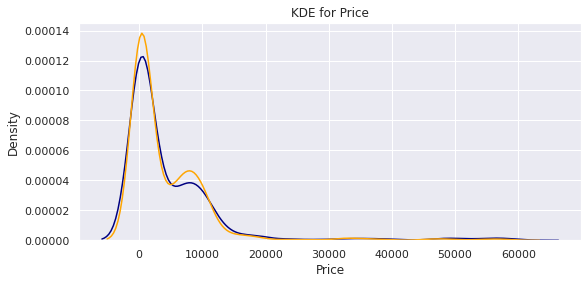

In [172]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df1[df['Direction'] == 'Up'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df1[df['Direction'] == 'Down'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('Price')


Analyze correlations with seaborn heatmap

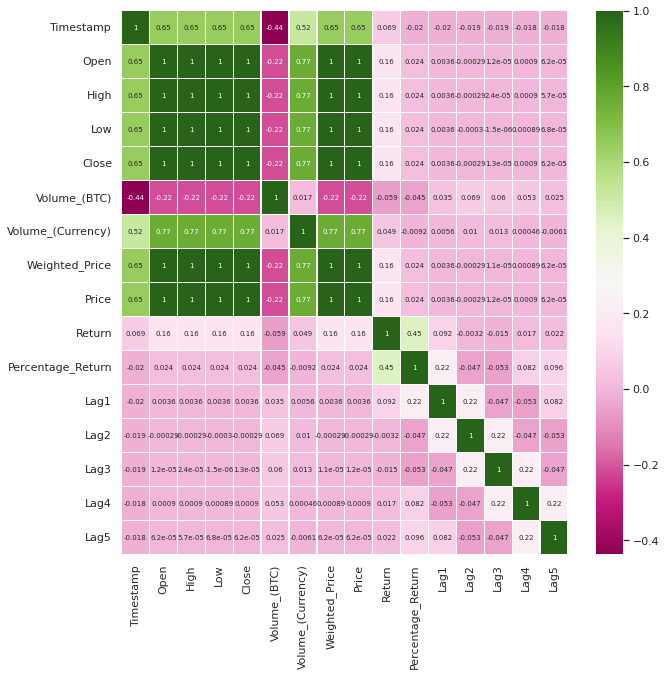

In [173]:
corr = df.corr()
plt.figure(figsize=[10,10])
plt.rcParams['font.size']=7
sns.heatmap(corr, cmap='PiYG', annot= True, linewidths=0.3 );

In [174]:
def triple_plot(x, title,c):
    fig, ax = plt.subplots(3,1,figsize=(25,10),sharex=True)
    sns.distplot(x, ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')
    sns.violinplot(x, ax=ax[2],color=c)
    ax[2].set(xlabel=None)
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=30)
    plt.tight_layout(pad=3.0)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


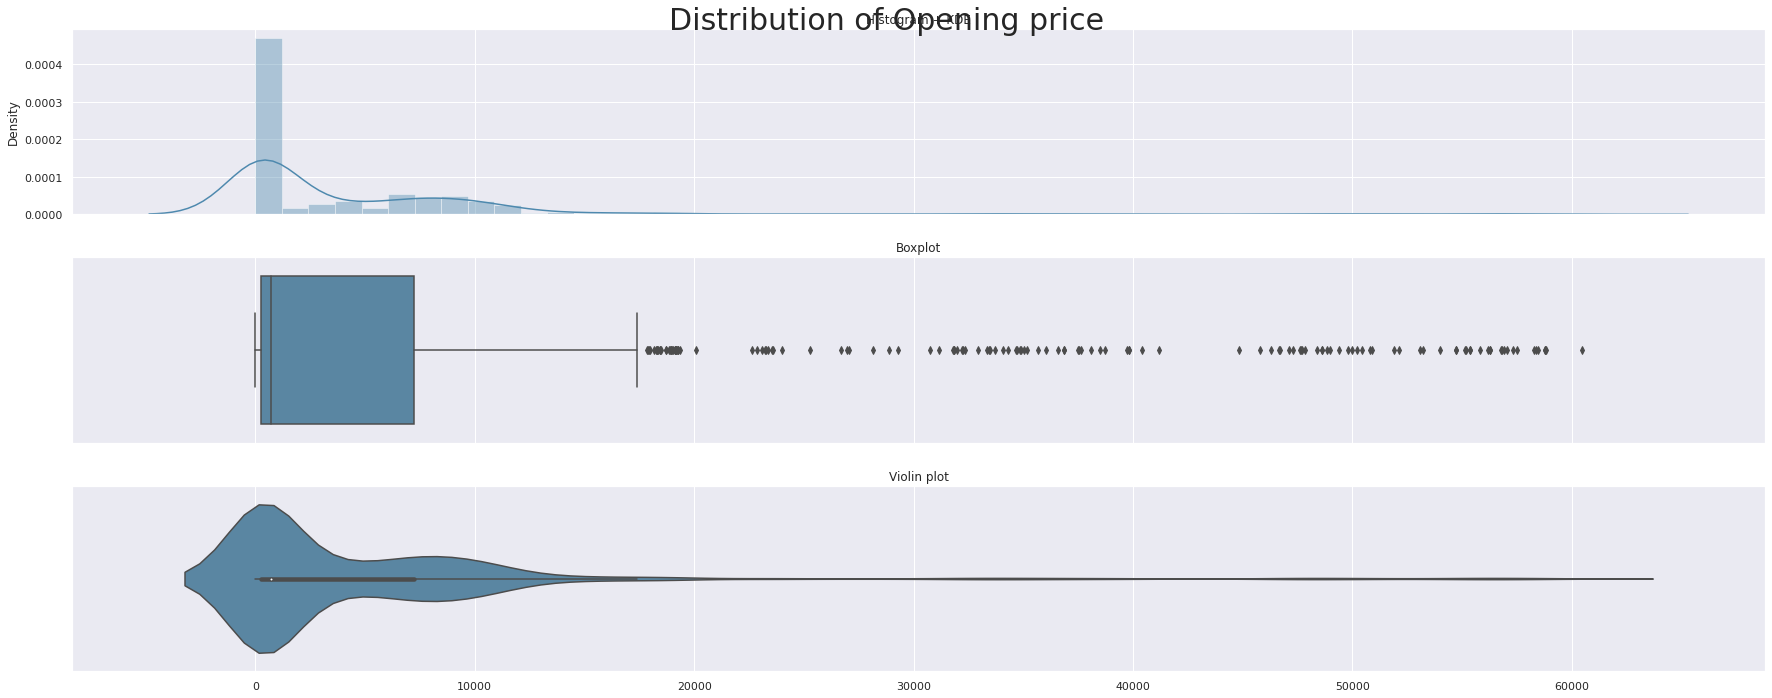

In [175]:
triple_plot(df['Open'],'Distribution of Opening price',custom_colors[0])

# **Linear Regression**

Ji Qi's part here

#**Logistics Regression**

Ji Qi's part here

#**ARIMA Model**

Geech's part here

# **Simple RNN**

Yihan Jia's part here

**It's just my initial idea, which may not be rigorous or wrong.**

In [176]:
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential

In [177]:
df.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Price,Return,Direction,Percentage_Return,Lag1,Lag2,Lag3,Lag4,Lag5
Date,,,,,,,,,,,,,,,,,
2011-12-31,1325346930,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,4.473750,NaN,Down,NaN,0.074416,0.040222,0.050500,-0.007774,0.205720
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667,4.806667,0.332917,Up,0.074416,0.040222,0.050500,-0.007774,0.205720,0.024856
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,5.000000,0.193333,Up,0.040222,0.050500,-0.007774,0.205720,0.024856,0.055901
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500,5.252500,0.252500,Up,0.050500,-0.007774,0.205720,0.024856,0.055901,0.022059
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159,5.211667,-0.040833,Down,-0.007774,0.205720,0.024856,0.055901,0.022059,-0.052818


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3376 entries, 2011-12-31 to 2021-03-31
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          3376 non-null   int64  
 1   Open               3376 non-null   float64
 2   High               3376 non-null   float64
 3   Low                3376 non-null   float64
 4   Close              3376 non-null   float64
 5   Volume_(BTC)       3376 non-null   float64
 6   Volume_(Currency)  3376 non-null   float64
 7   Weighted_Price     3376 non-null   float64
 8   Price              3376 non-null   float64
 9   Return             3375 non-null   float64
 10  Direction          3376 non-null   object 
 11  Percentage_Return  3375 non-null   float64
 12  Lag1               3375 non-null   float64
 13  Lag2               3374 non-null   float64
 14  Lag3               3373 non-null   float64
 15  Lag4               3372 non-null   float64
 16  Lag5          

In [179]:
Real_Price = df.groupby('Date')['Weighted_Price'].mean()

In [180]:
Real_Price.shape

(3376,)

In [183]:
# Split the dataset, take the data of last 30 days as the test set
prediction_days = 30
df_train = Real_Price[:len(Real_Price)-prediction_days]
df_test = Real_Price[len(Real_Price)-prediction_days:]

In [184]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [185]:
# Build the RNN model using Keras. 
# Choose some appropriate parameters.

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
53/53 [==============================] - 4s 18ms/step - loss: 0.0025
Epoch 2/100
53/53 [==============================] - 1s 18ms/step - loss: 0.0011
Epoch 3/100
53/53 [==============================] - 1s 19ms/step - loss: 0.0010
Epoch 4/100
53/53 [==============================] - 1s 19ms/step - loss: 8.1723e-04
Epoch 5/100
53/53 [==============================] - 1s 19ms/step - loss: 8.2680e-04
Epoch 6/100
53/53 [==============================] - 1s 18ms/step - loss: 5.9660e-04
Epoch 7/100
53/53 [==============================] - 1s 18ms/step - loss: 7.2080e-04
Epoch 8/100
53/53 [==============================] - 1s 18ms/step - loss: 7.8325e-04
Epoch 9/100
53/53 [==============================] - 1s 18ms/step - loss: 0.0011
Epoch 10/100
53/53 [==============================] - 1s 18ms/step - loss: 5.4593e-04
Epoch 11/100
53/53 [==============================] - 1s 18ms/step - loss: 8.1812e-04
Epoch 12/100
53/53 [==============================] - 1s 18ms/step - loss: 5.76

In [186]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

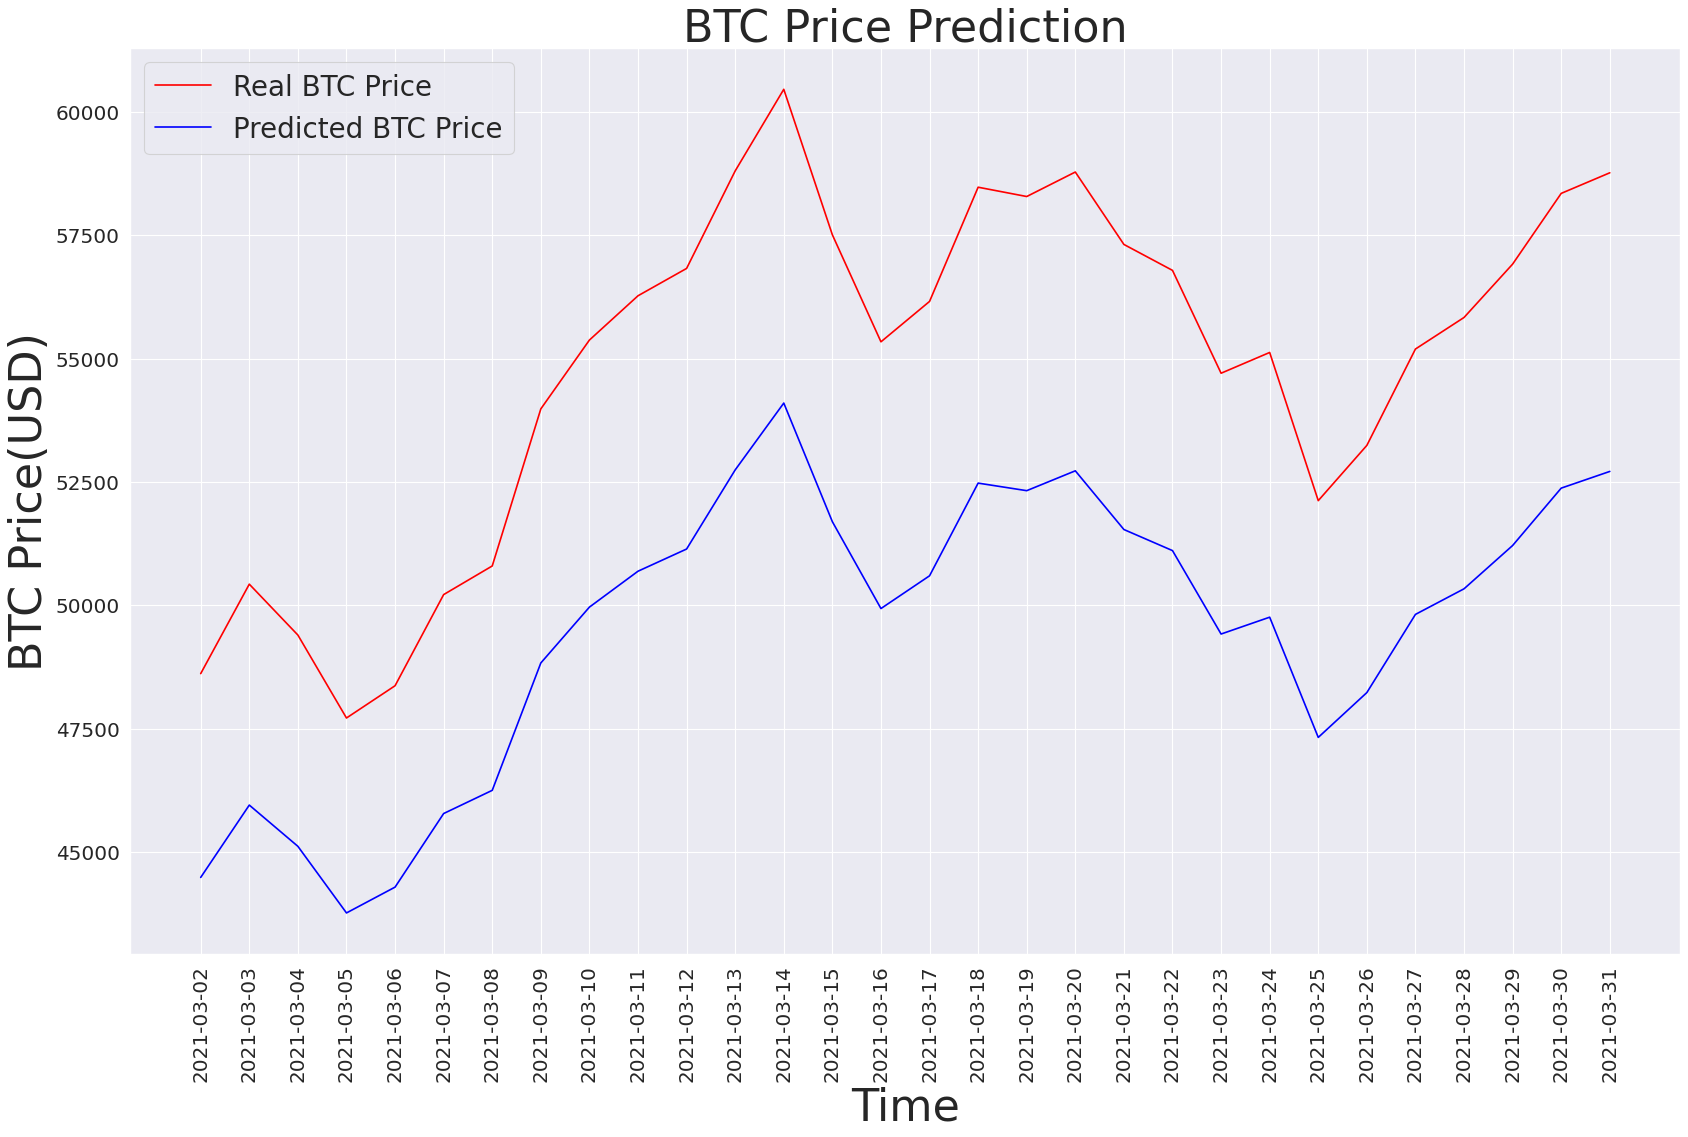

In [187]:
# Visualising the results
plt.figure(figsize = (25,15), dpi = 80, facecolor = 'w', edgecolor = 'k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize = 40)
df_test = df_test.reset_index()
x = df_test.index
labels = df_test['Date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize = 40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend(loc = 2, prop = {'size': 25})
plt.show()

In [ ]:
rmse = 

# **LSTM Model**

Chun Zhou and Vaibhav's part here

LSTM stands for long short-term memory networks. It is a variety of recurrent neural network (RNN) in the deep learning field. LSTM is effective when predicting sequence of data.

#**References**

1. "Bitcoin Price Prediction with LSTM". Ansel D'souza. https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm

2. How to Create an ARIMA Model for Time Series Forecasting in Python. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

3. How to Grid Search ARIMA Model Hyperparameters with Python. https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/